In [4]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, f1_score

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from torch.utils.data import Dataset


In [5]:
df = pd.read_csv("msrstratified_sample_5000.csv")
df.dropna(subset=["codeLink", "vul"], inplace=True)

print("Dataset Shape:", df.shape)
print("\nClass Distribution:")
print(df["vul"].value_counts())

df.head()


Dataset Shape: (5000, 36)

Class Distribution:
vul
0    2600
1    2400
Name: count, dtype: int64


,Unnamed: 0,Access Gained,Attack Origin,Authentication Required,Availability,CVE ID,CVE Page,CWE ID,Complexity,Confidentiality,...,lang,lines_after,lines_before,parentID,patch,project,project_after,project_before,vul,vul_func_with_fix
0,56106,NaN,Remote,Not required,Complete,CVE-2015-8963,https://www.cvedetails.com/cve/CVE-2015-8963/,CWE-416,High,Complete,...,C,NaN,NaN,NaN,"@@ -6488,9 +6488,6 @@ struct swevent_htable {\...",linux,12ca6ad2e3a896256f086497a7c7406a547ee373,c127449944659543e5e2423002f08f0af98dba5c,0,int perf_event_task_enable(void)\n{\n\tstruct ...
1,126503,NaN,Remote,Not required,Partial,CVE-2012-5148,https://www.cvedetails.com/cve/CVE-2012-5148/,CWE-20,Low,Partial,...,C,NaN,NaN,NaN,"@@ -1038,9 +1038,9 @@ void TabStripGtk::TabIns...",Chrome,e89cfcb9090e8c98129ae9160c513f504db74599,0c71b754680eb40b42ca1ce7a4e6fef7442b5da4,0,gfx::Image* TabStripGtk::GetDropArrowImage(boo...
2,181482,NaN,Remote,Not required,NaN,CVE-2017-7177,https://www.cvedetails.com/cve/CVE-2017-7177/,CWE-358,Low,NaN,...,C,"p1 = IPV6BuildTestPacket(IPPROTO_ICMPV6, i...","p1 = IPV6BuildTestPacket(id, 0, 1, 'A', 8)...",NaN,"@@ -996,8 +996,8 @@ void DefragDestroy(void)\n...",suricata,4a04f814b15762eb446a5ead4d69d021512df6f8,292baf0872abfebf2762e08e613565703595db6c,1,IPV6DefragReverseSimpleTest(void)\n{\n Defr...
3,139074,NaN,Remote,Not required,Partial,CVE-2015-1265,https://www.cvedetails.com/cve/CVE-2015-1265/,NaN,Low,Partial,...,C,NaN,NaN,NaN,"@@ -61,6 +61,7 @@ void ValidateRenderFrameId(i...",Chrome,04ff52bb66284467ccb43d90800013b89ee8db75,68dc18612e07009d613d3bbe4b22900e7d913f7e,0,AudioRendererHost::DoGetOutputControllers() co...
4,186579,NaN,Remote,Not required,Partial,CVE-2018-18339,https://www.cvedetails.com/cve/CVE-2018-18339/,CWE-119,Medium,Partial,...,C,break;\n break;\n,NaN,NaN,"@@ -731,9 +731,11 @@ void RendererSchedulerImp...",Chrome,e34e01b1b0987e418bc22e3ef1cf2e4ecaead264,5ef638ebf438e3786a221f691e3cb17be36b26a8,1,void RendererSchedulerImpl::OnShutdownTaskQueu...


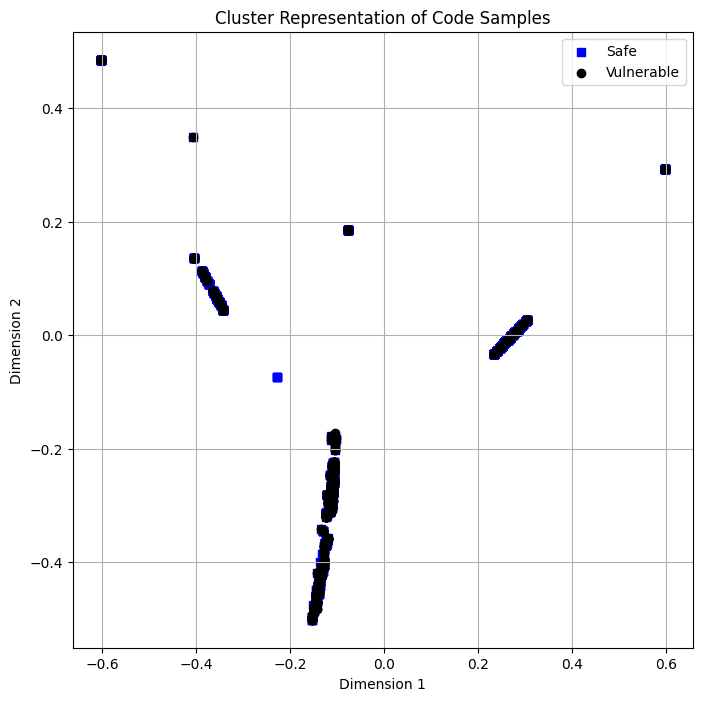

In [6]:
# Convert code text to numeric features
vectorizer = TfidfVectorizer(max_features=500)
X_features = vectorizer.fit_transform(df["codeLink"].astype(str))

# Reduce to 2D for plotting
pca = PCA(n_components=2)
X_cluster = pca.fit_transform(X_features.toarray())

labels = df["vul"].values

plt.figure(figsize=(8,8))

# Safe = Blue squares
plt.scatter(
    X_cluster[labels == 0, 0],
    X_cluster[labels == 0, 1],
    c='blue',
    marker='s',
    label='Safe'
)

# Vulnerable = Black circles
plt.scatter(
    X_cluster[labels == 1, 0],
    X_cluster[labels == 1, 1],
    c='black',
    marker='o',
    label='Vulnerable'
)

plt.title("Cluster Representation of Code Samples")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.grid(True)
plt.show()


In [7]:
CSV_FILE = "/Users/manmeetkaur/Downloads/msrstratified_sample_5000.csv"
TEXT_COL = "codeLink"
LABEL_COL = "vul"

MODEL_NAME = "microsoft/codebert-base"
EPOCHS = 3
BATCH_SIZE = 4
LR = 0.001
MAX_LEN = 128
RANDOM_SEED = 42

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)
torch.manual_seed(RANDOM_SEED)

Using device: mps


In [8]:
df = pd.read_csv(CSV_FILE)
print("Loaded data shape:", df.shape)
print(df[LABEL_COL].value_counts())


Loaded data shape: (5000, 36)
vul
0    2600
1    2400
Name: count, dtype: int64


In [9]:
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df[LABEL_COL],
    random_state=RANDOM_SEED
)

print("Train size:", len(train_df), "Val size:", len(val_df))
print("Train class counts:\n", train_df[LABEL_COL].value_counts())
print("Val class counts:\n", val_df[LABEL_COL].value_counts())


Train size: 4000 Val size: 1000
Train class counts:
 vul
0    2080
1    1920
Name: count, dtype: int64
Val class counts:
 vul
0    520
1    480
Name: count, dtype: int64


In [10]:
# Transformer-Based Code Preprocessing & Tokenization Pipeline

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

class CodeDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = list(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

train_dataset = CodeDataset(
    train_df[TEXT_COL],
    train_df[LABEL_COL],
    tokenizer,
    MAX_LEN
)

val_dataset = CodeDataset(
    val_df[TEXT_COL],
    val_df[LABEL_COL],
    tokenizer,
    MAX_LEN
)


In [11]:
# Compute class weights (make class 1 more important)

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler

train_labels = train_df[LABEL_COL].values
class_counts = np.bincount(train_labels)
print("Train class counts:", class_counts)

# weights for [class 0, class 1]
# You can tune 2.0–3.0; start with 2.5
class_weights = torch.tensor([1.0, 2.5], dtype=torch.float32).to(device)
print("Class weights tensor:", class_weights)

# Weighted sampler to show vulnerable samples more often
sample_weights = [class_weights[label].item() for label in train_labels]
sample_weights = torch.DoubleTensor(sample_weights)
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Train class counts: [2080 1920]
tensor([1.0000, 2.5000], device='mps:0')


In [12]:
# Model Definition and Loss Setup


model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)
model.to(device)

# ---- Focal Loss implementation ----
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce_loss = torch.nn.functional.cross_entropy(
            logits, targets, reduction="none"
        )
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()

criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
)
model.to(device)

# ---- Focal Loss implementation ----
class FocalLoss(torch.nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        ce_loss = torch.nn.functional.cross_entropy(
            logits, targets, reduction="none"
        )
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean()

criterion = FocalLoss(alpha=0.75, gamma=2.0)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
!pip install tqdm


In [15]:
# defining the training model

from tqdm import tqdm
import time
import gc

def train_model_verbose(model, train_loader, val_loader, optimizer, criterion, EPOCHS):
    train_losses = []
    val_losses = []
    val_accuracies = []
    epochs_list = []

    print("\n TRAINING STARTED")
    print(f"Total Epochs: {EPOCHS}")
    print(f"Steps per epoch: {len(train_loader)}")
    print("-" * 50)

    for epoch in range(1, EPOCHS + 1):
        start_time = time.time()
        model.train()
        total_train_loss = 0.0

        print(f"\n Epoch {epoch}/{EPOCHS} - Training...")

        # -------- TRAINING LOOP WITH PROGRESS BAR --------
        for batch_idx, batch in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch}")):
            optimizer.zero_grad()

            try:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            except RuntimeError as e:
                print(" Runtime error during training batch:", e)
                return None

        avg_train_loss = total_train_loss / len(train_loader)

        # -------- VALIDATION --------
        model.eval()
        total_val_loss = 0.0
        all_labels = []
        all_preds = []

        print(f" Epoch {epoch} - Validating...")

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch}"):
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                val_loss = criterion(logits, labels)
                total_val_loss += val_loss.item()

                probs = torch.softmax(logits, dim=1)[:, 1]
                preds = (probs > 0.4).long()

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)

        end_time = time.time()
        epoch_time = end_time - start_time

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        epochs_list.append(epoch)

        print(f"\n Epoch {epoch} Completed")
        print(f"Time: {epoch_time:.2f} seconds")
        print(f"Train Loss: {avg_train_loss:.4f}")
        print(f"Val Loss:   {avg_val_loss:.4f}")
        print(f"Val Acc:    {val_acc:.4f}")
        print("-" * 50)

        gc.collect()
        torch.mps.empty_cache()

    eval_results = classification_report(all_labels, all_preds, output_dict=True)

    print("\n TRAINING FINISHED")

    return {
        "model": model,
        "epochs": epochs_list,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "val_accuracies": val_accuracies,
        "eval_results": eval_results
    }


In [16]:
results = train_model_verbose(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    EPOCHS=EPOCHS
)



🚀 TRAINING STARTED
Total Epochs: 3
Steps per epoch: 1000
--------------------------------------------------

📘 Epoch 1/3 - Training...


Training Epoch 1: 100%|█████████████████████| 1000/1000 [05:27<00:00,  3.05it/s]


📙 Epoch 1 - Validating...


Validation Epoch 1: 100%|█████████████████████| 250/250 [00:13<00:00, 17.88it/s]



✅ Epoch 1 Completed
⏱ Time: 342.01 seconds
Train Loss: 0.7873
Val Loss:   4.8605
Val Acc:    0.4800
--------------------------------------------------

📘 Epoch 2/3 - Training...


Training Epoch 2: 100%|█████████████████████| 1000/1000 [05:25<00:00,  3.07it/s]


📙 Epoch 2 - Validating...


Validation Epoch 2: 100%|█████████████████████| 250/250 [00:12<00:00, 19.67it/s]



✅ Epoch 2 Completed
⏱ Time: 338.35 seconds
Train Loss: 0.9836
Val Loss:   1.8124
Val Acc:    0.4800
--------------------------------------------------

📘 Epoch 3/3 - Training...


Training Epoch 3: 100%|█████████████████████| 1000/1000 [05:21<00:00,  3.11it/s]


📙 Epoch 3 - Validating...


Validation Epoch 3: 100%|█████████████████████| 250/250 [00:13<00:00, 18.98it/s]



✅ Epoch 3 Completed
⏱ Time: 334.72 seconds
Train Loss: 0.8761
Val Loss:   0.3657
Val Acc:    0.5200
--------------------------------------------------

🎉 TRAINING FINISHED


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


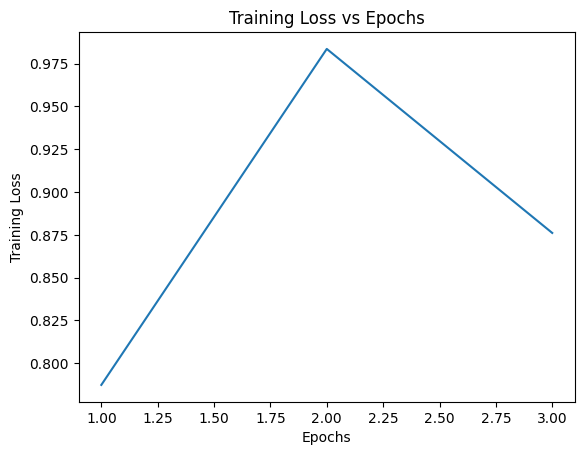

In [17]:
import matplotlib.pyplot as plt

epochs = results["epochs"]
train_losses = results["train_losses"]
val_losses = results["val_losses"]
val_accuracies = results["val_accuracies"]

# ===== 1. Training Loss vs Epochs =====
plt.figure()
plt.plot(epochs, train_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Epochs")
plt.show()

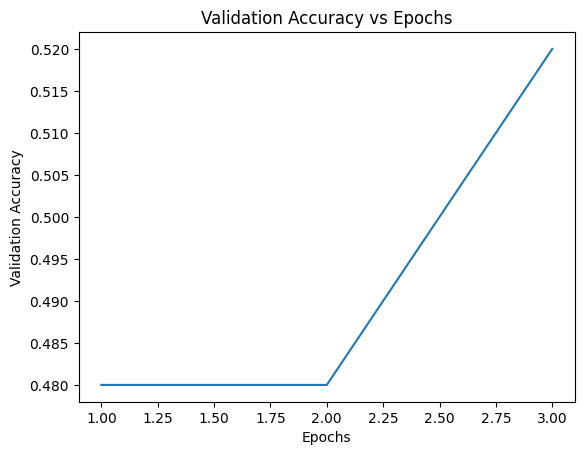

In [18]:
plt.figure()
plt.plot(epochs, val_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Epochs")
plt.show()


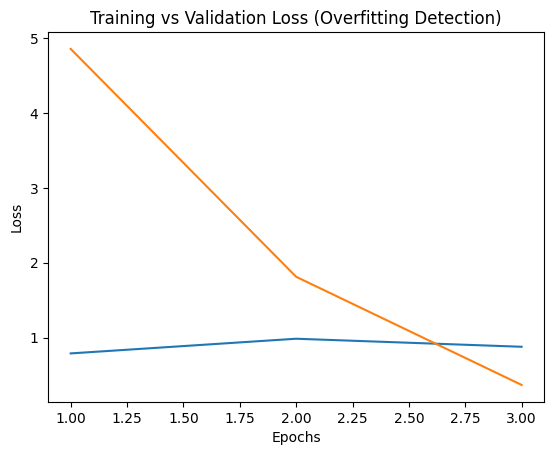

In [19]:
# ===== 3. Training vs Validation Loss =====
plt.figure()
plt.plot(epochs, train_losses)
plt.plot(epochs, val_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Overfitting Detection)")
plt.show()

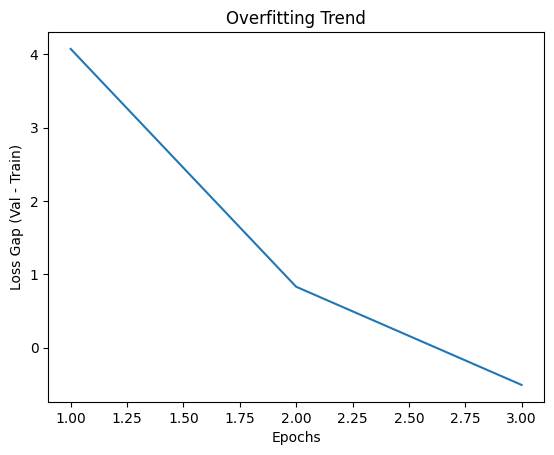

In [20]:
# ===== 4. Overfitting Detection Curve =====
loss_gap = [v - t for v, t in zip(val_losses, train_losses)]
plt.figure()
plt.plot(epochs, loss_gap)
plt.xlabel("Epochs")
plt.ylabel("Loss Gap (Val - Train)")
plt.title("Overfitting Trend")
plt.show()


In [21]:
# function will generate csv with code risk score

import pandas as pd
import torch
from tqdm import tqdm

def generate_code_risk_csv(model, dataframe, tokenizer, output_path):
    model.eval()
    risks = []

    print("🚀 Generating code risk scores...")

    with torch.no_grad():
        for code in tqdm(dataframe["codeLink"], desc="Scoring code"):
            enc = tokenizer(
                str(code),
                padding="max_length",
                truncation=True,
                max_length=128,
                return_tensors="pt"
            )

            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)

            vulnerability_prob = probs[0][1].item()  # probability of class 1
            risks.append(vulnerability_prob)

    dataframe["code_risk_score"] = risks
    dataframe[["code_risk_score"]].to_csv(output_path, index=False)

    print("✅ Code risk CSV saved to:", output_path)


In [26]:
trained_model = results["model"]

OUTPUT_CSV = "/Users/manmeetkaur/Downloads/code_risk_scores.csv"

generate_code_risk_csv(
    model=trained_model,
    dataframe=df,
    tokenizer=tokenizer,
    output_path=OUTPUT_CSV
)


🚀 Generating code risk scores...


Scoring code: 100%|█████████████████████████| 5000/5000 [01:23<00:00, 60.16it/s]

✅ Code risk CSV saved to: /Users/manmeetkaur/Downloads/code_risk_scores.csv


In [27]:
# function will generate csv with code risk score, vulnerability label, risk level, confidence

def generate_code_risk_csv(model, dataframe, tokenizer, output_path, threshold=0.5):
    model.eval()

    risks = []
    labels = []
    levels = []
    confidences = []

    print("🚀 Generating extended code risk report...")

    with torch.no_grad():
        for code in dataframe["codeLink"]:
            enc = tokenizer(
                str(code),
                padding="max_length",
                truncation=True,
                max_length=128,
                return_tensors="pt"
            )

            input_ids = enc["input_ids"].to(device)
            attention_mask = enc["attention_mask"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)[0]

            prob_vulnerable = probs[1].item()
            prediction = int(prob_vulnerable > threshold)

            # Risk level classification
            if prob_vulnerable > 0.7:
                level = "HIGH"
            elif prob_vulnerable > 0.4:
                level = "MEDIUM"
            else:
                level = "LOW"

            risks.append(prob_vulnerable)
            labels.append(prediction)
            levels.append(level)
            confidences.append(round(prob_vulnerable * 100, 2))

    output_df = pd.DataFrame({
        "code": dataframe["codeLink"],
        "code_risk_score": risks,
        "vulnerability_label": labels,
        "risk_level": levels,
        "confidence_percent": confidences
    })

    output_df.to_csv(output_path, index=False)

    print("✅ Extended Code Risk CSV saved to:", output_path)
    print("Columns exported:", output_df.columns.tolist())


In [29]:
trained_model = results["model"]

OUTPUT_CSV = "/Users/manmeetkaur/Downloads/code_risk_scores_detailed.csv"

generate_code_risk_csv(
    model=trained_model,
    dataframe=df,
    tokenizer=tokenizer,
    output_path=OUTPUT_CSV,
    threshold=0.4
)


🚀 Generating extended code risk report...
✅ Extended Code Risk CSV saved to: /Users/manmeetkaur/Downloads/code_risk_scores_detailed.csv
Columns exported: ['code', 'code_risk_score', 'vulnerability_label', 'risk_level', 'confidence_percent']


Loaded CSV with columns: ['code_risk_score']


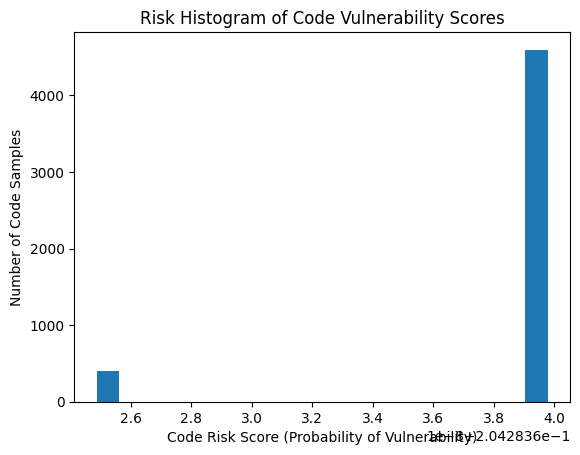

In [30]:
# code-risk histogram 

import pandas as pd
import matplotlib.pyplot as plt


csv_path = "/Users/manmeetkaur/Downloads/code_risk_scores.csv"

df = pd.read_csv(csv_path)

print("Loaded CSV with columns:", df.columns.tolist())

plt.figure()
plt.hist(df["code_risk_score"].dropna(), bins=20)
plt.xlabel("Code Risk Score (Probability of Vulnerability)")
plt.ylabel("Number of Code Samples")
plt.title("Risk Histogram of Code Vulnerability Scores")
plt.show()


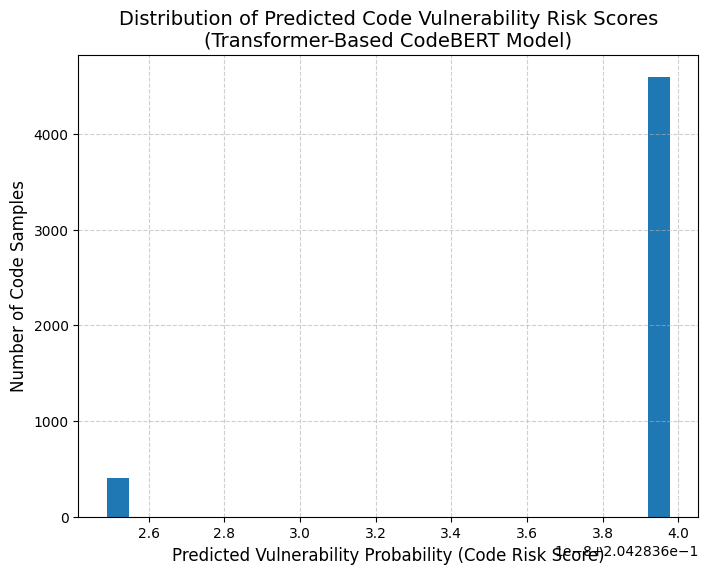

In [31]:
plt.figure(figsize=(8,6))

plt.hist(df["code_risk_score"].dropna(), bins=25)

plt.xlabel("Predicted Vulnerability Probability (Code Risk Score)", fontsize=12)
plt.ylabel("Number of Code Samples", fontsize=12)

plt.title(
    "Distribution of Predicted Code Vulnerability Risk Scores\n"
    "(Transformer-Based CodeBERT Model)",
    fontsize=14
)

plt.grid(True, linestyle="--", alpha=0.6)

plt.show()


In [33]:
import torch
import torch.nn as nn
from transformers import AutoModel

class CodeBERTWithDropout(nn.Module):
    def __init__(self, model_name, dropout_rate=0.3, num_labels=2):
        super(CodeBERTWithDropout, self).__init__()
        self.codebert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.codebert.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.codebert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        pooled_output = outputs.last_hidden_state[:, 0]  # CLS token
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)

        return type("obj", (object,), {"logits": logits})


In [34]:
model_with_dropout = CodeBERTWithDropout(
    model_name=MODEL_NAME,
    dropout_rate=0.4  # strong regularization
).to(device)


In [35]:
model.train()  # activates dropout
model.eval()   # disables dropout


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [36]:
results_with_dropout = train_model_verbose(
    model=model_with_dropout,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    EPOCHS=EPOCHS
)



🚀 TRAINING STARTED
Total Epochs: 3
Steps per epoch: 1000
--------------------------------------------------

📘 Epoch 1/3 - Training...


Training Epoch 1: 100%|█████████████████████| 1000/1000 [03:13<00:00,  5.18it/s]


📙 Epoch 1 - Validating...


Validation Epoch 1: 100%|█████████████████████| 250/250 [00:13<00:00, 18.37it/s]



✅ Epoch 1 Completed
⏱ Time: 206.78 seconds
Train Loss: 0.2100
Val Loss:   0.1469
Val Acc:    0.4480
--------------------------------------------------

📘 Epoch 2/3 - Training...


Training Epoch 2: 100%|█████████████████████| 1000/1000 [03:09<00:00,  5.27it/s]


📙 Epoch 2 - Validating...


Validation Epoch 2: 100%|█████████████████████| 250/250 [00:12<00:00, 19.56it/s]



✅ Epoch 2 Completed
⏱ Time: 202.49 seconds
Train Loss: 0.2070
Val Loss:   0.1469
Val Acc:    0.4480
--------------------------------------------------

📘 Epoch 3/3 - Training...


Training Epoch 3: 100%|█████████████████████| 1000/1000 [03:09<00:00,  5.29it/s]


📙 Epoch 3 - Validating...


Validation Epoch 3: 100%|█████████████████████| 250/250 [00:12<00:00, 19.65it/s]



✅ Epoch 3 Completed
⏱ Time: 201.94 seconds
Train Loss: 0.2082
Val Loss:   0.1469
Val Acc:    0.4480
--------------------------------------------------

🎉 TRAINING FINISHED


In [37]:
model_without_dropout = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2
).to(device)

results_without_dropout = train_model_verbose(
    model=model_without_dropout,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    EPOCHS=EPOCHS
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🚀 TRAINING STARTED
Total Epochs: 3
Steps per epoch: 1000
--------------------------------------------------

📘 Epoch 1/3 - Training...


Training Epoch 1: 100%|█████████████████████| 1000/1000 [03:18<00:00,  5.03it/s]


📙 Epoch 1 - Validating...


Validation Epoch 1: 100%|█████████████████████| 250/250 [00:13<00:00, 18.88it/s]



✅ Epoch 1 Completed
⏱ Time: 212.06 seconds
Train Loss: 0.1444
Val Loss:   0.1308
Val Acc:    0.4800
--------------------------------------------------

📘 Epoch 2/3 - Training...


Training Epoch 2: 100%|█████████████████████| 1000/1000 [03:33<00:00,  4.69it/s]


📙 Epoch 2 - Validating...


Validation Epoch 2: 100%|█████████████████████| 250/250 [00:13<00:00, 19.01it/s]



✅ Epoch 2 Completed
⏱ Time: 226.72 seconds
Train Loss: 0.1436
Val Loss:   0.1308
Val Acc:    0.4800
--------------------------------------------------

📘 Epoch 3/3 - Training...


Training Epoch 3: 100%|█████████████████████| 1000/1000 [03:37<00:00,  4.61it/s]


📙 Epoch 3 - Validating...


Validation Epoch 3: 100%|█████████████████████| 250/250 [00:13<00:00, 18.51it/s]



✅ Epoch 3 Completed
⏱ Time: 230.76 seconds
Train Loss: 0.1436
Val Loss:   0.1308
Val Acc:    0.4800
--------------------------------------------------

🎉 TRAINING FINISHED


/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


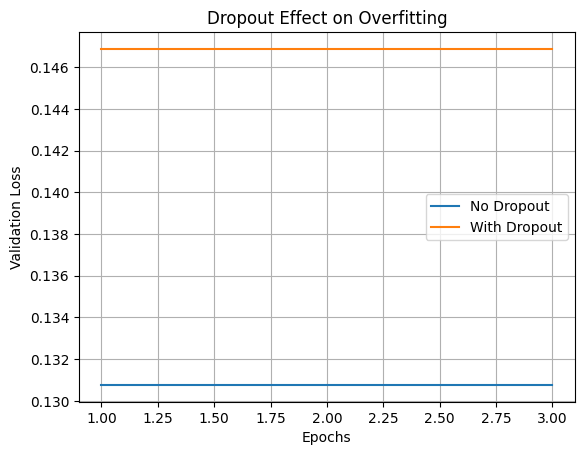

In [38]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(results_without_dropout["epochs"], results_without_dropout["val_losses"], label="No Dropout")
plt.plot(results_with_dropout["epochs"], results_with_dropout["val_losses"], label="With Dropout")

plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Dropout Effect on Overfitting")
plt.legend()
plt.grid(True)
plt.show()


In [39]:
import pandas as pd
import torch
from tqdm import tqdm

def generate_code_risk_csv(model, dataframe, tokenizer, output_path):
    model.eval()
    risks = []

    print("🚀 Generating production code risk scores...")

    with torch.no_grad():
        for code in tqdm(dataframe["codeLink"].astype(str)):
            inputs = tokenizer(
                code,
                max_length=256,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            ).to(device)

            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)

            risk_score = probs[0][1].item()   # probability of vulnerable
            risks.append(risk_score)

    dataframe["code_risk_score"] = risks

    dataframe[["code_risk_score"]].to_csv(output_path, index=False)
    print(f"✅ Production CSV created: {output_path}")


In [40]:
OUTPUT_CSV = "/Users/manmeetkaur/Downloads/code_risk_with_dropout.csv"

generate_code_risk_csv(
    model=model_with_dropout,     # ✅ dropout model
    dataframe=df,                 # your original dataset
    tokenizer=tokenizer,
    output_path=OUTPUT_CSV
)


🚀 Generating production code risk scores...


KeyError: 'codeLink'

In [41]:
def generate_code_risk_csv(model, dataframe, tokenizer, output_path):
    model.eval()
    risks = []

    # ✅ AUTO-DETECT CODE COLUMN
    possible_cols = ["codeLink", "code", "snippet", "source", "content", "text"]
    code_column = None

    for col in possible_cols:
        if col in dataframe.columns:
            code_column = col
            break

    if code_column is None:
        raise ValueError(f"No code column found. Available columns: {dataframe.columns.tolist()}")

    print(f"✅ Using code column: {code_column}")
    print("🚀 Generating code risk scores...")

    for code in dataframe[code_column].astype(str):
        inputs = tokenizer(
            code,
            truncation=True,
            padding="max_length",
            max_length=256,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)
            risk_score = probs[:, 1].item()  # probability of vulnerable class

        risks.append(risk_score)

    dataframe["code_risk_score"] = risks

    dataframe[["code_risk_score"]].to_csv(output_path, index=False)
    print(f"✅ Production-ready CSV saved to: {output_path}")


In [43]:
OUTPUT_CSV = "/Users/manmeetkaur/Downloads/code_risk_scores_with_dropout.csv"

df[["code_risk_score"]].to_csv(OUTPUT_CSV, index=False)

print(f"✅ Production-ready CSV saved successfully at:\n{OUTPUT_CSV}")


✅ Production-ready CSV saved successfully at:
/Users/manmeetkaur/Downloads/code_risk_scores_with_dropout.csv
